In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/hm/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [26]:
import json
import pathlib
import collections
import itertools

import pandas as pd
import plotnine as p9

from drl_cc import scores_util as su
from drl_cc import path_util as pu
from drl_cc import tennis

In [3]:
tuning_results_dir = pathlib.Path('../training_output/tuning_ddpg')

In [4]:
resources_dir = pathlib.Path("../training_output/tuning_results")
resources_dir.mkdir(exist_ok=True, parents=True)

In [5]:
expected_filenames = {
    'metadata.json', 
    'training_params.json',  
    'weights_critic.pth',
    'scores.csv',     
    'weights_actor.pth'
}

In [6]:
agent_dirs = [
    d for d in tuning_results_dir.glob("**/**") 
    if set([p.name for p in d.glob("*")]) == expected_filenames 
]
agent_dirs

[PosixPath('../training_output/tuning_ddpg/62c5680b-5abd-405b-aed2-3d8e49659778/001'),
 PosixPath('../training_output/tuning_ddpg/62c5680b-5abd-405b-aed2-3d8e49659778/002'),
 PosixPath('../training_output/tuning_ddpg/172d722d-adb4-4526-b102-464617e3b43d/001'),
 PosixPath('../training_output/tuning_ddpg/172d722d-adb4-4526-b102-464617e3b43d/002')]

In [7]:
agent_results = []
for i, p in enumerate(agent_dirs):
    with open(p.joinpath('training_params.json')) as f:
        training_params = json.load(f)
    df_scores = pd.read_csv(p.joinpath('scores.csv'), index_col=None)
    df_scores['agent_id'] = i
    r = (training_params, df_scores)
    agent_results.append(r)

In [8]:
df_scores = pd.concat([df for _, df in agent_results])
df_scores['agent_id'] = df_scores['agent_id'].astype(str)
df_scores = df_scores.loc[df_scores['episode'], :]
df_scores

,episode,score,score_avg100,time_steps,time_ep,time_total,agent_id
0,0,0.00,0.0000,15,0.078103,0.078104,0
0,0,0.00,0.0000,13,0.045879,0.045880,1
0,0,0.00,0.0000,14,0.047544,0.047545,2
0,0,0.00,0.0000,14,0.053600,0.053602,3
1,1,0.09,0.0450,30,0.229347,0.308337,0
...,...,...,...,...,...,...,...
1022,1022,2.60,0.4994,1001,114.711205,7739.681192,3
1023,1023,0.00,0.4854,3,0.246317,7739.928450,3
1024,1024,0.20,0.4864,80,9.409130,7749.338529,3
1025,1025,1.49,0.4973,558,62.316707,7811.655958,3


/home/hm/anaconda3/envs/drlnd/lib/python3.6/site-packages/plotnine/utils.py:284: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/hm/anaconda3/envs/drlnd/lib/python3.6/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/hm/anaconda3/envs/drlnd/lib/python3.6/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


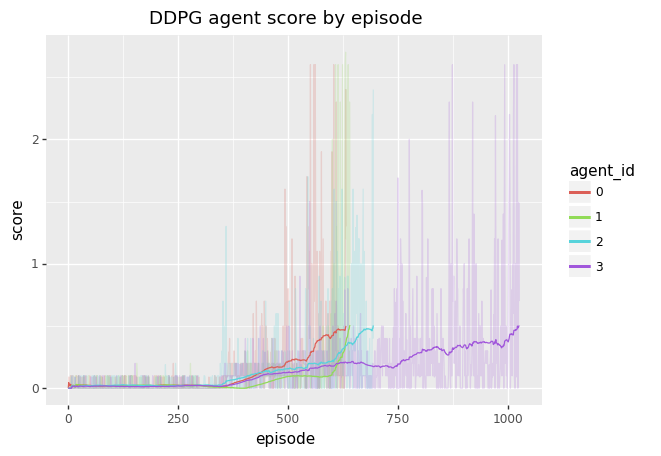

<ggplot: (8785880678941)>

In [9]:
scores_plot = (
    p9.ggplot(data=df_scores, mapping=p9.aes(x="episode", y="score", group="agent_id", color='agent_id')) + 
    p9.geom_line(alpha=0.2) +
    p9.geom_line(mapping=p9.aes(x="episode", y="score_avg100", group="agent_id", color="agent_id")) +
    p9.ggtitle("DDPG agent score by episode")
)
scores_plot

In [10]:
scores_plot.save(str(resources_dir.joinpath("scores_all.png")))

/home/hm/anaconda3/envs/drlnd/lib/python3.6/site-packages/plotnine/ggplot.py:552: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(h, units), units))


In [11]:
c = collections.Counter(itertools.chain.from_iterable(r[0].items() for r in agent_results))

In [12]:
common_params = dict((k for k, v in c.items() if v == len(agent_results)))
common_params

{'n_episodes': 3000,
 'gamma_discount_factor': 0.95,
 'mean_score_threshold': 0.5,
 'max_t': 1000,
 'learning_rate_actor': 0.003,
 'learning_rate_critic': 0.001,
 'tau_soft_update': 0.003,
 'l2_weight_decay': 0,
 'has_ou_noise': True,
 'ou_noise_mu': 0.0,
 'ou_noise_theta': 0.15,
 'ou_noise_sigma_start': 0.4,
 'ou_noise_sigma_end': 0.05,
 'ou_noise_sigma_decay': 0.9,
 'n_random_episodes': 300,
 'agent_seed': 11111,
 'logging_freq': 1}

In [13]:
df_common_params = pd.DataFrame.from_records(list(common_params.items()), columns=['parameter', 'value'])
df_common_params

,parameter,value
0,n_episodes,3000
1,gamma_discount_factor,0.95
2,mean_score_threshold,0.5
3,max_t,1000
4,learning_rate_actor,0.003
5,learning_rate_critic,0.001
6,tau_soft_update,0.003
7,l2_weight_decay,0
8,has_ou_noise,True
9,ou_noise_mu,0


In [14]:
df_common_params.to_csv(resources_dir.joinpath("common_hyperparams.csv"), index=False)

In [15]:
! csv2md {str(resources_dir.joinpath("common_hyperparams.csv"))}

| parameter             | value |
| --------------------- | ----- |
| n_episodes            | 3000  |
| gamma_discount_factor | 0.95  |
| mean_score_threshold  | 0.5   |
| max_t                 | 1000  |
| learning_rate_actor   | 0.003 |
| learning_rate_critic  | 0.001 |
| tau_soft_update       | 0.003 |
| l2_weight_decay       | 0     |
| has_ou_noise          | True  |
| ou_noise_mu           | 0.0   |
| ou_noise_theta        | 0.15  |
| ou_noise_sigma_start  | 0.4   |
| ou_noise_sigma_end    | 0.05  |
| ou_noise_sigma_decay  | 0.9   |
| n_random_episodes     | 300   |
| agent_seed            | 11111 |
| logging_freq          | 1     |


In [16]:
varying_param_names = sorted(set((k[0] for k, v in c.items() if v != len(agent_results) and k[0] != 'agent_seed')))
varying_param_names

['batch_size', 'buffer_size', 'num_updates', 'update_every']

In [17]:
columns = ['agent_id'] + varying_param_names + ['n_episodes_to_solve']
rows = [
    tuple([str(i)] + [tp[p] for p in varying_param_names] + [df.shape[0] - 100]) 
    for i, (tp, df) in enumerate(agent_results)
]
df_agent_params = pd.DataFrame.from_records(rows, index=None, columns=columns)
df_agent_params

,agent_id,batch_size,buffer_size,num_updates,update_every,n_episodes_to_solve
0,0,128,100000,5,1,533
1,1,128,100000,5,1,542
2,2,1024,1000000,10,2,595
3,3,1024,1000000,10,2,927


In [18]:
df_agent_params.to_csv(resources_dir.joinpath("agent_hyperparams.csv"), index=False)

In [19]:
! csv2md {str(resources_dir.joinpath("agent_hyperparams.csv"))}

| agent_id | batch_size | buffer_size | num_updates | update_every | n_episodes_to_solve |
| -------- | ---------- | ----------- | ----------- | ------------ | ------------------- |
| 0        | 128        | 100000      | 5           | 1            | 533                 |
| 1        | 128        | 100000      | 5           | 1            | 542                 |
| 2        | 1024       | 1000000     | 10          | 2            | 595                 |
| 3        | 1024       | 1000000     | 10          | 2            | 927                 |


In [20]:
! ls ../training_output/tuning_ddpg/62c5680b-5abd-405b-aed2-3d8e49659778/001/

metadata.json  training_params.json  weights_critic.pth
scores.csv     weights_actor.pth


In [21]:
! ls ../training_output/tuning_ddpg/62c5680b-5abd-405b-aed2-3d8e49659778/001

metadata.json  training_params.json  weights_critic.pth
scores.csv     weights_actor.pth


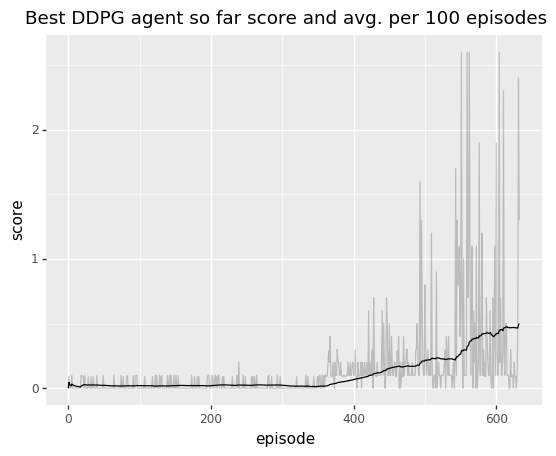

<ggplot: (-9223363250974851696)>

In [22]:
df_scores = su.read_scores(pathlib.Path("../training_output/tuning_ddpg/62c5680b-5abd-405b-aed2-3d8e49659778/001"))
best_scores_plot = (
    p9.ggplot(data=df_scores, mapping=p9.aes(x="episode", y="score")) + 
    p9.geom_line(alpha=0.2) +
    p9.geom_line(mapping=p9.aes(x="episode", y="score_avg100")) +
    p9.ggtitle("Best DDPG agent so far score and avg. per 100 episodes")
)
best_scores_plot

In [23]:
best_scores_plot.save("../img/best_agent_so_far.png")